### Model Description

Model: Siamese Convolutional AE <br>
Augmentation: 4-point OpenCV Perspective Transform + random brightness change <br>
Train Dataset: The City Centre <br>
Test Dataset: The New College <br>

### Import all the necessary libraries

In [1]:
from pylab import *
import os, sys, tarfile, base64
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from random import randint
from math import sqrt

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K 
from tensorflow_addons.optimizers import Lookahead, RectifiedAdam
from tensorflow.keras.preprocessing.image import *
import tensorflow_addons as tfa
from tensorflow.keras.utils import *

from skimage.io import imread
from skimage.transform import resize
import cv2

GPUs:  1


### Load the dataset for training the model

In [2]:
# Load the New College dataset
newcollege_images_path = "./NewCollege"

newcollege = sorted(
    [str(newcollege_images_path +"/"+ f) for f in os.listdir(newcollege_images_path)]
)

# Load the City Centre dataset
citycentre_images_path = "./CityCentre"

citycentre = sorted(
    [str(citycentre_images_path +"/"+ f) for f in os.listdir(citycentre_images_path)]
)

print(f"The New College dataset has {len(newcollege)} images.")
print(f"The City Centre dataset has {len(citycentre)} images.")

The New College dataset has 2146 images.
The City Centre dataset has 2474 images.


### Load the ground truths

In [3]:
newcollege_gt = np.loadtxt("./NewCollegeGroundTruth.txt", delimiter=',')
citycentre_gt = np.loadtxt("./CityCentreGroundTruth.txt", delimiter=',')

### Load the GPS coordinates

In [4]:
with open("./NewCollegeGPS.txt", 'r') as f:
    newcollege_gps = [line.split()[1:] for line in f]
    
# Converting to float for further work
newcollege_gps = np.array(newcollege_gps, dtype=np.float32)

# Deleting all the NaN values from the set - this problem only occurs in New College
newcollege_gps = newcollege_gps[:1984]

print(f"New size New College: {len(newcollege_gps)}")

with open("./CityCentreGPS.txt", 'r') as f:
    citycentre_gps = [line.split()[1:] for line in f]
    
# Converting to float for further work
citycentre_gps = np.array(citycentre_gps, dtype=np.float32)


print(f"New size City Centre: {len(citycentre_gps)}")

New size New College: 1984
New size City Centre: 2474


### Camera Calibration

This information was provided in the dataset description:

In [5]:
# Focal length:
fc = [ 367.481519978327754 , 366.991059667167065 ]
# Principal point:
cc = [ 328.535778962615268 , 233.779960757465176 ]
# Distortion coefficients:
kc = [ -0.293510277812333 ,
        0.065334967950619 ,
       -0.000117308680498 ,
        0.000304779905426 ,
        0.000000000000000 ]

im_width  = 640
im_height = 480

### Preprocessing / Augmentation

In [6]:
def preprocess_image(filename, standard_shape = (96, 128)):
    """
    Load the specified file as a JPEG image, 
    convert to float32 to work with it,
    correct the fish-eye distortion,
    resize it to the target shape.
    """
    fnameb64 = './cache/' + base64.b64encode(f'{filename}{standard_shape}'.encode('utf-8')).decode('utf-8')
    if os.path.isfile(fnameb64):
        data = np.fromfile(open(fnameb64, 'rb'), dtype=float32)
        if len(data) == standard_shape[0]*standard_shape[1]*3:
            data = data.reshape(standard_shape[0],standard_shape[1],3)
            return data
    
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)           
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = undistort_fish_eye(image.numpy())
    image = tf.image.resize(image, standard_shape)
    with open(fnameb64,'wb') as f:
        data = float32(image.numpy())
        data.tofile(f)
    return image

def unison_shuffle(arr1, arr2):
    """
    Shuffles two arrays while preserving the indices
    """
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return [arr1[i] for i in p], [arr2[i] for i in p]


def unison_shuffle_triple(arr1, arr2, arr3):
    """
    Shuffles three arrays while preserving the indices
    """
    assert len(arr1) == len(arr2) and len(arr2)== len(arr3)
    p = np.random.permutation(len(arr1))
    return [arr1[i] for i in p], [arr2[i] for i in p], [arr3[i] for i in p]

def undistort_fish_eye(src):
    """
    Gets rid of the fish eye camera distortion
    """
    width  = src.shape[1]
    height = src.shape[0]

    # Distortion coefficients
    distCoeff = np.float32(kc) 

    # Initial unit matrix for the camera
    cam = np.eye(3,dtype=np.float32)

    cam[0,2] = cc[0]        # principal point x
    cam[1,2] = cc[1]        # principal point y
    cam[0,0] = fc[0]        # focal length x
    cam[1,1] = fc[1]        # focal length y

    # Compute the fish-eye neutralisation
    dst = cv2.undistort(src,cam,distCoeff)
    return dst


def four_point_transform(image):   
    """
    Applies a 4-point transformation to an image 
    """
    try:
        image = image.numpy()
    except:
        pass
    
    maxWidth = image.shape[1]
    maxHeight = image.shape[0]
    XDELTA = 15
    YDELTA = 15
    
    # Choose the points in the corners of the image to perform the transform
    src = np.array([
        (randint(0,XDELTA), randint(0, YDELTA)),
        (randint(maxWidth-XDELTA, maxWidth-1), randint(0, YDELTA)),         
        (randint(maxWidth-XDELTA, maxWidth-1), randint(maxHeight-YDELTA, maxHeight-1)),
        (randint(0,XDELTA), randint(maxHeight-YDELTA, maxHeight-1)),
    ], dtype='float32')
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight)).reshape((maxHeight,maxWidth,3))
    # Return the warped image
    return warped


def augment(image):
    """
    Applies all the necessary augmentations to the image:
    the 4-point transform and the brightness change
    """    
    im2 = image
    
    # Do the 4-point transform
    if rand() < 0.5:
        im2 = four_point_transform(im2)
        
    # Change the brightness up or down and clip to the maximal values of 0 and 1
    if rand() < 0.5:
        im2 = clip( im2 * (0.25 + rand() * 1.5), 0.0, 1.0)
        im2 *= (0.95 + rand(3)*0.1)
    return im2

### Functions to split a dataset into train/test
These split functions are not used in the final version of the algorithm, yet they may come in handy should anyone want to run the experiment on each dataset - New College or City Centre - separately

In [7]:
# def train_test_split(dataset_full, percentage=0.8):
#     """
#     Split the dataset into train and validation subsets 
#     percentage: training size
#     """
#     num = len(dataset_full)
#     train_dataset = dataset_full[ :round(num * percentage)]
#     val_dataset   = dataset_full[round(num * percentage): ]
#     return train_dataset, val_dataset


# def train_test_split_n(dataset_full, number=100):
#     """
#     Split the dataset into train and validation subsets 
#     number: the number of images in the validation dataset
#     """
#     if type(dataset_full) is tuple:
#         train_dataset = (dataset_full[0][ :-number], dataset_full[1][ :-number])
#         val_dataset   = (dataset_full[0][-number: ], dataset_full[1][-number: ])
#     else:
#         train_dataset = dataset_full[ :-number]
#         val_dataset   = dataset_full[-number: ]
#     return train_dataset, val_dataset

### From the extracted GPS coordinates we could see the full route of the robot

Text(0.5, 0, 'City Centre route')

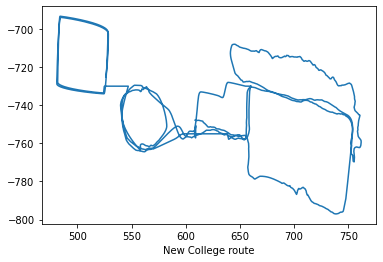

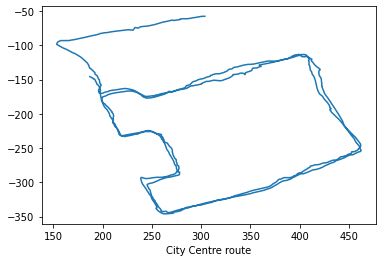

In [8]:
plot(newcollege_gps[:,0], newcollege_gps[:,1])
xlabel("New College route")
figure()
plot(citycentre_gps[:,0], citycentre_gps[:,1])
xlabel("City Centre route")

### Calculate the distance between images using GPS data

In [9]:
def distanceP(a, b):
    """
    Gives a distance between two GPS coordinates
    """
    return sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [10]:
# Test the distance between 2 images
distanceP(newcollege_gps[1033], newcollege_gps[629])

7.793019843830316

Using function distanceP, for every image we could plot how far from it other images have been taken 

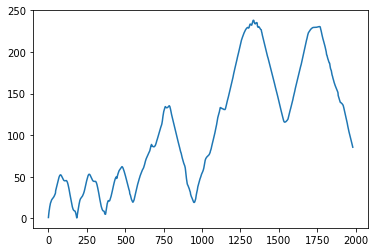

In [11]:
# Plot the distance from image 1 in New College to the rest of the images
plot([distanceP(newcollege_gps[0], newcollege_gps[q]) for q in range(1,len(newcollege_gps))])

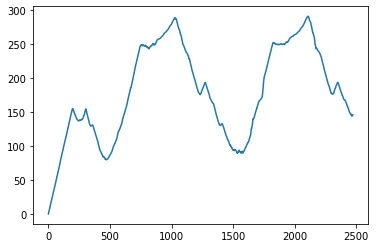

In [12]:
# Plot the distance from image 1 in City Centre to the rest of the images
plot([distanceP(citycentre_gps[0], citycentre_gps[q]) for q in range(1,len(citycentre_gps))])

## Create Dataset of Closures and Non-closures

In [13]:
def createInputOutput(imageset, gt, gps):
    """
    Create a large input dataset combining similar
    and dissimilar pairs, as well as corresponding outputs.
    """
    
    l = len(imageset)    
    data_n1 = []
    data_n2 = []
    data_p1 = []
    data_p2 = []
    
    DELTA_MAX = 3
    
    DELTA_MIN = 200
    
    l = min(l, len(gps))
    
    # Assemble the dataset of closures / non-closures
    for st in range(0,2):
        for i in range(st,l,2):
            for j in range(st,l,2):
                if float(gt[i][j]) > 0 and distanceP(gps[i], gps[j]) <= DELTA_MAX:
                    data_p1.append(i)
                    data_p2.append(j)
                    
                elif distanceP(gps[i], gps[j]) >= DELTA_MIN:
                    data_n1.append(i)
                    data_n2.append(j)
                            
    ridx = np.random.permutation(len(data_n1))
    data_n1 = int32(data_n1)[ridx].copy()
    data_n2 = int32(data_n2)[ridx].copy()
    
    print(f'After normalising: Closures {len(data_p1)}, Non-closures {len(data_n1)}')
    
    # Shuffle the final dataset    
    data1n, data2n, outputn = unison_shuffle_triple(data_n1, data_n2, zeros_like(data_n1))
    data1p, data2p, outputp = unison_shuffle_triple(data_p1, data_p2, ones_like(data_p1))
    return (data1n, data1p), (data2n, data2p), (outputn, outputp)
    

In [14]:
"""
Assemble the train and test datasets fromCity Centre and New College respectively:
data1     - image 1 from the pair
data2     - image 2 from the pair
out       - closure or non-closure
train/val - training and validation sets respectively
"""

inputData1NC, inputData2NC, outputDataNC = createInputOutput(newcollege, newcollege_gt, newcollege_gps)

inputData1CC, inputData2CC, outputDataCC = createInputOutput(citycentre, citycentre_gt, citycentre_gps)


trainData1 = inputData1CC
trainData2 = inputData2CC
trainDataOut = outputDataCC

valData1 = inputData1NC
valData2 = inputData2NC
valDataOut = outputDataNC

After normalising: Closures 1825, Non-closures 209310
After normalising: Closures 1839, Non-closures 800694


<Figure size 648x648 with 0 Axes>

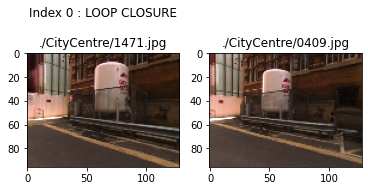

<Figure size 648x648 with 0 Axes>

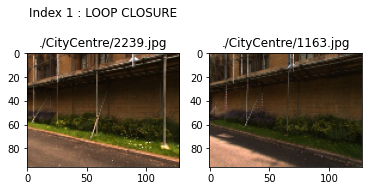

<Figure size 648x648 with 0 Axes>

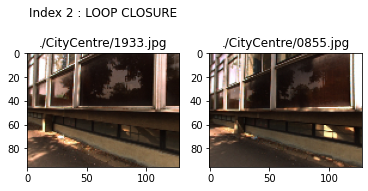

<Figure size 648x648 with 0 Axes>

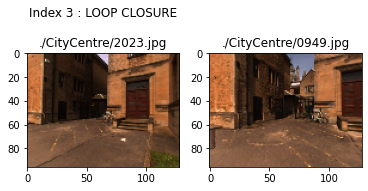

<Figure size 648x648 with 0 Axes>

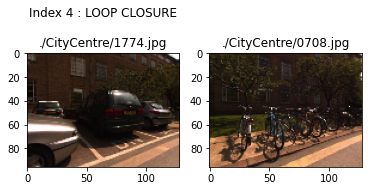

<Figure size 648x648 with 0 Axes>

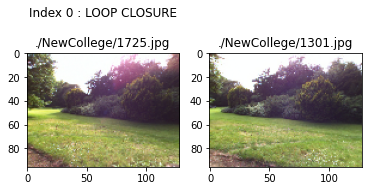

<Figure size 648x648 with 0 Axes>

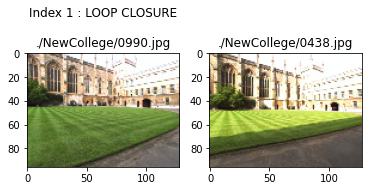

<Figure size 648x648 with 0 Axes>

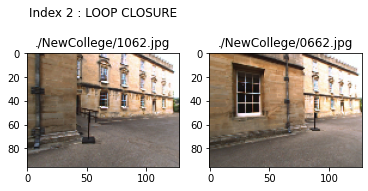

<Figure size 648x648 with 0 Axes>

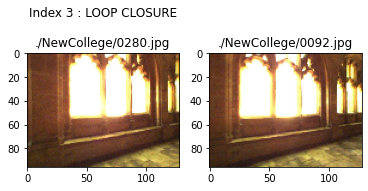

<Figure size 648x648 with 0 Axes>

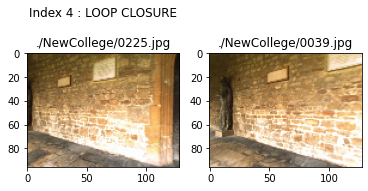

In [15]:
def visualize(imageset, indx, part1, part2, out_):
    """
    Show a random pair of dataset images
    to visually verify their similarity.
    """
    if type(part1) is tuple:
        q = indx % 2
        indx = indx // 2
        img1    = part1[q][indx]
        img2    = part2[q][indx]  
        verdict = out_[q][indx]
    else:
        img1    = part1[indx]
        img2    = part2[indx]  
        verdict = out_[indx]

    if verdict > 0:
        fig = plt.figure(figsize=(9, 9))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title(f'Index {indx} : {"LOOP CLOSURE" if verdict else "NOT LOOP CLOSURE"}\n\n{imageset[img1]}')
        ax1.imshow(preprocess_image(imageset[img1]))
        ax2.set_title(f'{imageset[img2]}')
        ax2.imshow(preprocess_image(imageset[img2]))       

# Visualise sample pairs from the datasets
for i in range(10):
    visualize(citycentre, i, trainData1, trainData2, trainDataOut)
for i in range(10):
    visualize(newcollege, i, valData1, valData2, valDataOut)

## Siamese Convolutional Autoencoder

The present autoencoder is necessary to pre-train, so that it learns how to create a low-dimentional descriptors of images in its bottleneck through the encoding-decoding process.

In [16]:
def ACT():
    """
    The activation function.
    """
    return Activation('relu')

# The two lines above are for training on multi-GPU systems
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    aemodel = Sequential([
        Input((96,128,3)),
        Conv2D(filters=32,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2D(filters=48,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2D(filters=64,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2D(filters=96,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2D(filters=128, kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,4), strides=1, padding="valid"), ACT(), BatchNormalization(),

        Conv2DTranspose(filters=256, kernel_size=(3,4), strides=1, padding="valid"), ACT(), BatchNormalization(),
        Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2DTranspose(filters=96,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2DTranspose(filters=64,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2DTranspose(filters=48,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2DTranspose(filters=32,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
        Conv2DTranspose(filters=3,   kernel_size=5, strides=1, padding="same"),
        Activation("sigmoid"),
    ])

    def gaus(x):
        """
        Gaussian blur 
        """
        return tfa.image.gaussian_filter2d(x,(7,7),sigma=3)

    def hp(x):
        """
        High pass: Enhance edges
        """
        return x + (x-gaus(x))*2

    aemodel.compile(
        loss=lambda t,p: tf.math.reduce_mean(tf.abs(hp(t-p))**2), 
        optimizer=Lookahead(RectifiedAdam(lr=0.01))
    )
    aemodel.summary()
    aemodel.load_weights('cc-nc-g-aemodel-checkpoint256')



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

### Image Generator for the AE

In [17]:
def genImages(data1, imageset):
    """
    The image generator generating batches of 700 images,  
    imageset - to specify either citycentre or newcollege
    """
    while True:
        insA = [ ]
        outs = [ ]
        for i in range(700):
            q = randint(0,1)
            ridx = randint(0, len(data1[q])-1)
            ccp = f'q{q}i{ridx}'
            img = clip(augment(preprocess_image(imageset[data1[q][ridx]])), 0.0, 1.0)
            insA.append(img)
            outs.append(img)
        
        yield float32(insA), float32(outs)
        
def genImages2():
    """
    The image generator specifically for the AE, 
    generating batches of 700 images of 
    both the datasets - citycentre and newcollege
    """
    while True:
        insA = [ ]
        outs = [ ]
        for i in range(350):
            data1 = trainData1
            imageset = citycentre
            q = randint(0,1)
            ridx = randint(0, len(data1[q])-1)
            img = clip(augment(preprocess_image(imageset[data1[q][ridx]])), 0.0, 1.0)
            insA.append(img)
            outs.append(img)

            data1 = valData1
            imageset = newcollege            
            q = randint(0,1)
            ridx = randint(0, len(data1[q])-1)
            img = clip(augment(preprocess_image(imageset[data1[q][ridx]])), 0.0, 1.0)
            insA.append(img)
            outs.append(img)

        yield float32(insA), float32(outs)        

### Train the autoencoder

In [18]:
if False:
    for step in range(100):
        history = aemodel.fit(
            genImages2(),
            epochs=100,
            steps_per_epoch=100,
            callbacks = [
                tf.keras.callbacks.TensorBoard(log_dir='./logs'),
                ReduceLROnPlateau(
                    monitor="loss",
                    factor=0.2,
                    patience=5,
                    verbose=1,
                ),
                EarlyStopping(
                    monitor="loss",
                    patience=5,
                    verbose=1,
                    restore_best_weights=True,
                ),
                ModelCheckpoint(
                    'cc-nc-g-aemodel-checkpoint256',
                    monitor="loss",
                    save_best_only=True,
                    save_weights_only=True,
                ),
            ]
        )

### Test the autoencoder's performance

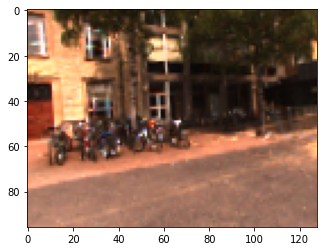

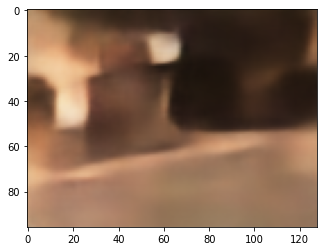

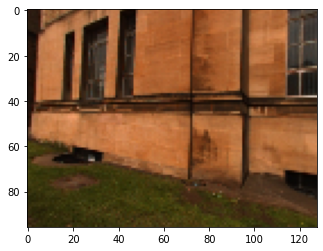

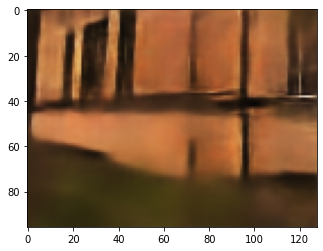

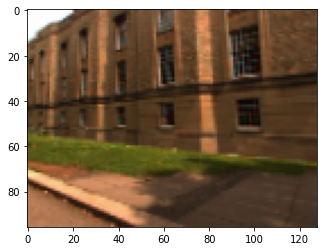

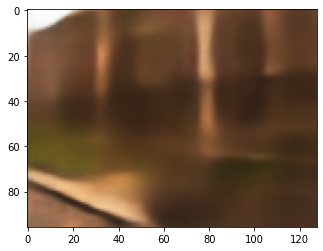

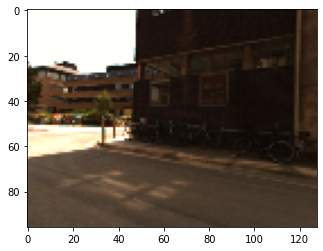

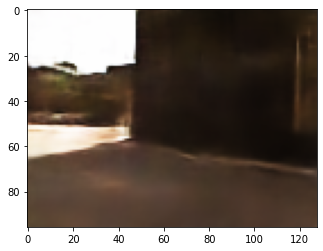

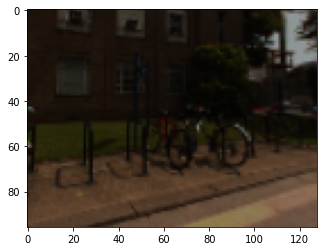

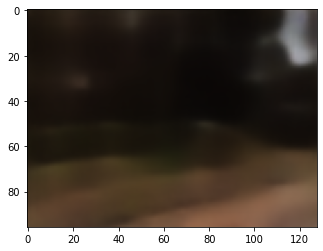

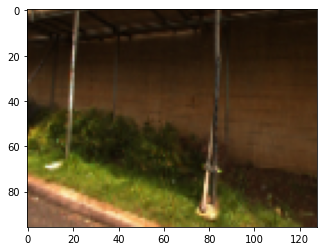

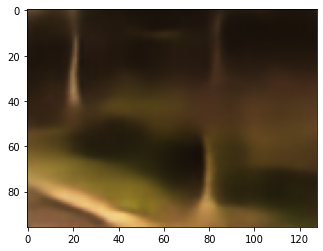

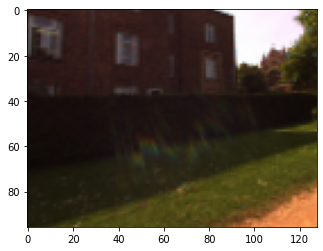

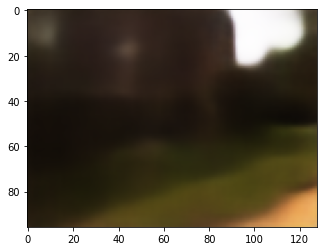

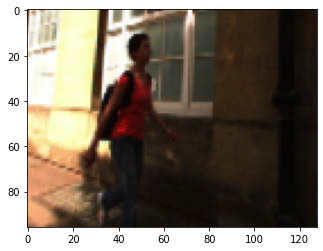

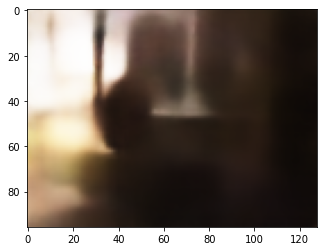

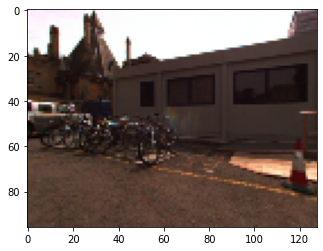

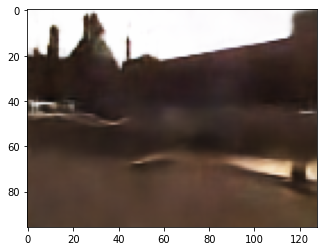

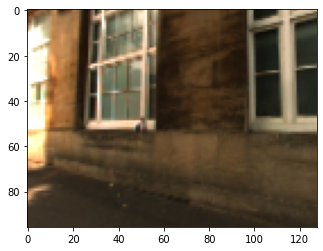

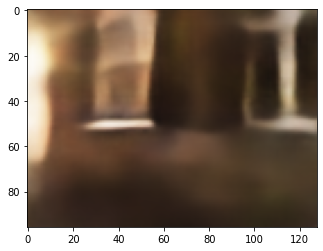

In [19]:
def testAE():
    gg = genImages(trainData1,citycentre)
    g = next(gg)
    rg = aemodel.predict(g[0])
    for i in range(10):
        figure()
        #imshow(clip(hp(g[0][i]),0.0,1.0))
        imshow(clip((g[0][i]),0.0,1.0))
        figure()
        imshow(clip(rg[i],0.0,1.0))

testAE()

### Siamese convolutional neural network

In [20]:
# Define the inputs' sizes
a = Input((96,128,3)) 
b = Input((96,128,3))

def ACT():
    """
    Activation function.
    """
    return Activation('relu')

# A Siamese branch part 
model = Sequential([
    Conv2D(filters=32,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
    Conv2D(filters=48,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
    Conv2D(filters=64,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
    Conv2D(filters=96,  kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
    Conv2D(filters=128, kernel_size=5, strides=2, padding="same"), ACT(), BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,4), strides=1, padding="valid"), ACT(), BatchNormalization(),
    Flatten(),
])

# Let both the inputs through the branches
encoded_image_1 = model(a) 
encoded_image_2 = model(b)

# Concatenate the resulting low-dimensional descriptors into one
descriptor = concatenate([encoded_image_1, encoded_image_2])

# The dense "decision" layers
final_layer = Flatten()(descriptor)
final_layer = Dense(1024,activation=ACT())(final_layer)
final_layer = BatchNormalization()(final_layer)
final_layer = Dense(512,activation=ACT())(final_layer) 
final_layer = BatchNormalization()(final_layer)
final_layer = Dense(256,activation=ACT())(final_layer) 
final_layer = BatchNormalization()(final_layer)
final_layer = Dense(128,activation=ACT())(final_layer)
final_layer = BatchNormalization()(final_layer)
final_layer = Dense(1, activation='sigmoid')(final_layer)

# Assemble the entire neural network together
siamese_autoencoder = Model(inputs=[a,b], outputs = final_layer)

# Make the Siamese branches trainable (change both True to False otherwise)
for i in range(len(model.layers)-1):
    model.layers[i].trainable = True
model.trainable = True

# Compile the final model
siamese_autoencoder.compile(
    loss='binary_crossentropy', 
    optimizer=Lookahead(RectifiedAdam(lr = 0.01)),
    metrics=["accuracy", 
             tf.keras.metrics.Precision(), 
             tf.keras.metrics.Recall(), 
             tf.keras.metrics.AUC(curve="PR")]
)

# Print the summary of the main model and the Siamese branches
siamese_autoencoder.summary()
model.summary()

# Set the coefficients for the branches to the pre-trained ones
for i in range(len(model.layers)-1):
    model.layers[i].set_weights(aemodel.layers[i].get_weights())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 256)          974736      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           sequential_1[0][0]           

### Data Generator
Data generator for the Siamese NN

In [21]:
class DataSequence(tf.keras.utils.Sequence):
    """
    imageset - the dataset to use as a source image collection 
    data1, data2, output - two arrays of images to compare and their output
    batch_size - how many images to generate
    aug - enable augmentation if True
    """
    def __init__(self, imageset, data1, data2, output, batch_size=256, aug=True):
        super().__init__()
        self.data1 = data1
        self.data2 = data2
        self.output = output
        self.batch_size = batch_size
        self.internalCounter = 0
        self.imageset = imageset
        self.aug = aug

    def __len__(self):
        return math.ceil(len(self.data1) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        insA = [ ]
        insB = [ ]
        outs = [ ]
        maxel = self.batch_size
        for i in range(maxel):
            q = randint(0,1)
            ridx = randint(0, len(self.data1[q])-1)
            if self.aug and q==1 and rand()<0.1: # every Nth image is the same
                q = 0
                ridx = randint(0, len(self.data1[q])-1)
                insA.append(augment(preprocess_image(self.imageset[self.data1[q][ridx]])))
                insB.append(augment(preprocess_image(self.imageset[self.data1[q][ridx]])))
                outs.append(1.0)
            else:                
                if self.aug:
                    insA.append(augment(preprocess_image(self.imageset[self.data1[q][ridx]])))
                    insB.append(augment(preprocess_image(self.imageset[self.data2[q][ridx]])))
                else:
                    insA.append(preprocess_image(self.imageset[self.data1[q][ridx]]))
                    insB.append(preprocess_image(self.imageset[self.data2[q][ridx]]))

                outs.append(self.output[q][ridx])
        
        return (float32(insA),float32(insB)), float32(outs)

x_train = DataSequence(citycentre, trainData1, trainData2, trainDataOut, batch_size=200)    
x_val   = DataSequence(newcollege, valData1, valData2,   valDataOut,   batch_size=100, aug=False)   


# Generator as a function
def funcGen(gen):
    while(True):
        for ex in gen:
            yield ex

### Train the main model

In [22]:
for step in range(100):
    history = siamese_autoencoder.fit(
        funcGen(x_train),
        epochs=100,
        steps_per_epoch=100,
        validation_data = funcGen(x_val),
        validation_steps = 100,
        callbacks = [
            ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.2,
                patience=5,
                verbose=1,
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=5,
                verbose=1,
                restore_best_weights=True,
            ),
            ModelCheckpoint(
                'cc-nc-g-checkpoint',
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
            ),
        ]
    )

Epoch 1/100
100/100 [==============================] - 39s 300ms/step - loss: 0.5494 - accuracy: 0.7193 - precision: 0.7172 - recall: 0.7226 - auc: 0.7812 - val_loss: 0.3307 - val_accuracy: 0.8605 - val_precision: 0.8291 - val_recall: 0.9063 - val_auc: 0.9326
Epoch 2/100
100/100 [==============================] - 29s 288ms/step - loss: 0.1114 - accuracy: 0.9600 - precision: 0.9542 - recall: 0.9662 - auc: 0.9905 - val_loss: 0.4458 - val_accuracy: 0.8615 - val_precision: 0.8570 - val_recall: 0.8675 - val_auc: 0.8844
Epoch 3/100
100/100 [==============================] - 29s 289ms/step - loss: 0.0656 - accuracy: 0.9760 - precision: 0.9730 - recall: 0.9791 - auc: 0.9968 - val_loss: 0.4302 - val_accuracy: 0.8805 - val_precision: 0.8231 - val_recall: 0.9685 - val_auc: 0.9371
Epoch 4/100
100/100 [==============================] - 31s 309ms/step - loss: 0.0515 - accuracy: 0.9812 - precision: 0.9806 - recall: 0.9813 - auc: 0.9978 - val_loss: 0.9082 - val_accuracy: 0.8786 - val_precision: 0.8305

### Plot a sample of what generator gives

In [ ]:
# sample = funcGen(x_train)
# s = next(sample)
# for i in range(5):
#     figure()
#     imshow(s[0][0][i])
#     figure()
#     imshow(s[0][1][i])

### Plot evaluation metrics
(of course, the plot is not for the entire history, but only for the last several epochs due to the EarlyStopping)

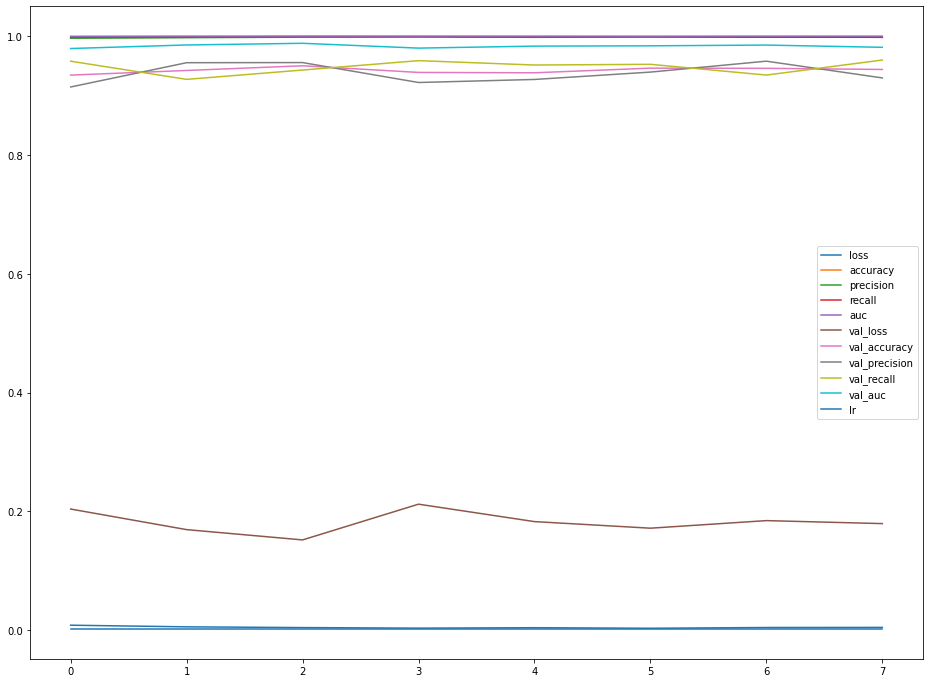

In [23]:
figure(figsize=(16,12))
for k in history.history.keys():
    plot(history.history[k], label=k)
    
legend()

### Check the mispredicted samples

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

Total = 100     Mispredicted = 4
Accuracy = 0.96


<Figure size 1152x1152 with 0 Axes>

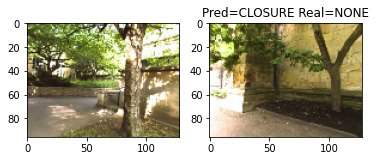

<Figure size 1152x1152 with 0 Axes>

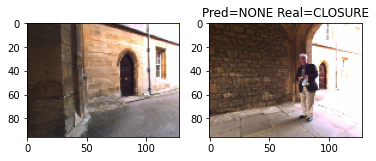

<Figure size 1152x1152 with 0 Axes>

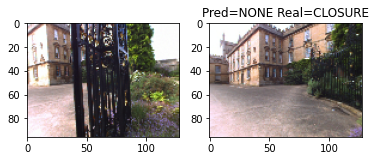

<Figure size 1152x1152 with 0 Axes>

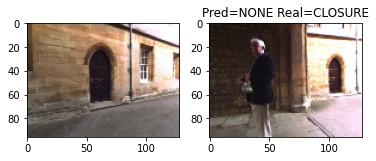

In [38]:
total = 0
mispredicted = 0
from tqdm import tqdm
x_check = x_val
for data in tqdm(x_check):
    predOut = int32((siamese_autoencoder.predict(data[0]).flatten() > 0.5) * 1.0)
    realOut = int32(data[1].flatten())
    for i,(p,r) in enumerate(zip(predOut, realOut)):
        total += 1
        if p != r:
            mispredicted += 1
            if mispredicted <= 10: # only show 10 first mismatches
                fig = plt.figure(figsize=(16, 16))
                fig, (ax1, ax2) = plt.subplots(1, 2)
                plt.title(f'Pred={"CLOSURE" if p else "NONE"} Real={"CLOSURE" if r else "NONE"}')
                ax1.imshow(data[0][0][i])
                ax2.imshow(data[0][1][i])
print(f'Total = {total}     Mispredicted = {mispredicted}')
print(f'Accuracy = {1.0 - mispredicted/total}')